# Goal

The goal of this notebook is to figure out if there is a "general region of the sella" which can be used to presize the dataset items.

## Hypothesis

The sella bbox is similar between dataset items with similar dimensions.

# Data Path

Set path to where data is stored.

In [3]:
# Get path to 4 TB HD

# /media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home

# wsl: /home/rgologorsky/DeepPit
hd_path = "../" * 5 + "/media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a" + "/home/rachel/PitMRdata"

# all folders in HD
all_folders = os.listdir(hd_path)

print(all_folders)

# labels
print(os.listdir(f"{hd_path}/samir_labels"))

['ABIDE', 'PPMI', 'ABVIB', 'samir_labels']
['50155-50212', '50373-50453', '50002-50153', '50213-50312', '50313-50372']


# Imports

In [4]:
# imports

from faimed3d.all import *
from fastai import *
from torchvision.models.video import r3d_18
from fastai.callback.all import SaveModelCallback
from torch import nn

import os
import time
import pickle
from pathlib import Path

import SimpleITK as sitk
import meshio

import numpy as np
import pandas as pd
from pandas import DataFrame as DF

from helpers_preprocess import get_data_dict, paths2objs, folder2objs, seg2mask

from helpers_general import sitk2np, print_sitk_info, round_tuple, lrange, lmap, get_roi_range, numbers2groups

# imports
from helpers_general import sitk2np, np2sitk, round_tuple, lrange, get_roi_range, numbers2groups
from helpers_preprocess import mask2bbox, print_bbox, get_bbox_size, print_bbox_size, get_data_dict, folder2objs
from helpers_viz import viz_axis

# Get Items

Item = (path to MR, path to Segmentation obj)

In [6]:
# get items = (mask_fn, nii_fn)
train_path = f"{hd_path}/samir_labels"
folders = os.listdir(train_path)

# get all items
data_dict_full = {}
for folder in folders:
    data_dict_full.update(get_data_dict(f"{train_path}/{folder}"))

items_full = list(data_dict_full.values())
print(f"Full data dict: {len(data_dict_full)} items.")

Full data dict: 335 items.


## Metadata

Check size, spacing, orientation, etc of the items in the dataset.

In [8]:
# load metadata about fns -- size, spacing, etc
full_metadata_df = pd.read_pickle(f"./samir_labels.pkl") #./50155-50212.pkl")

full_metadata_df

,folder,fn,imputedSeq,sz,px,sp,dir
0,50198,../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50155-50212/50198/MP-RAGE/2000-01-01_00_00_00.0/S164832/ABIDE_50198_MRI_MP-RAGE_br_raw_20120830184954222_S164832_I328842.nii,MPR,"(172, 256, 256)",16-bit signed integer,"(1.0, 1.0, 1.0)","(1, 0, 0, 0, -1, 0, 0, 0, 1)"
1,50171,../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50155-50212/50171/MP-RAGE/2000-01-01_00_00_00.0/S165626/ABIDE_50171_MRI_MP-RAGE_br_raw_20120831121139312_S165626_I329670.nii,MPR,"(160, 239, 200)",16-bit signed integer,"(1.1, 1.0, 1.0)","(1, 0, 0, 0, -1, 0, 0, 0, 1)"
2,50190,../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50155-50212/50190/MP-RAGE/2000-01-01_00_00_00.0/S165172/ABIDE_50190_MRI_MP-RAGE_br_raw_20120830213356334_S165172_I329182.nii,MPR,"(172, 256, 256)",16-bit signed integer,"(1.0, 1.0, 1.0)","(1, 0, 0, 0, -1, 0, 0, 0, 1)"
3,50188,../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50155-50212/50188/MP-RAGE/2000-01-01_00_00_00.0/S164322/ABIDE_50188_MRI_MP-RAGE_br_raw_20120830150918614_S164322_I328316.nii,MPR,"(172, 256, 256)",16-bit signed integer,"(1.0, 1.0, 1.0)","(1, 0, 0, 0, -1, 0, 0, 0, 1)"
4,50212,../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50155-50212/50212/MP-RAGE/2000-01-01_00_00_00.0/S164537/ABIDE_50212_MRI_MP-RAGE_br_raw_20120830164957961_S164537_I328540.nii,MPR,"(172, 256, 256)",16-bit signed integer,"(1.0, 1.0, 1.0)","(1, 0, 0, 0, -1, 0, 0, 0, 1)"
...,...,...,...,...,...,...,...
55,50317,../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50313-50372/50317/MP-RAGE/2000-01-01_00_00_00.0/S165101/ABIDE_50317_MRI_MP-RAGE_br_raw_20120830204520973_S165101_I329111.nii,MPR,"(256, 256, 116)",16-bit signed integer,"(1.02, 1.02, 1.4)","(1, 0, 0, 0, -1, 0, 0, 0, 1)"
56,50326,../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50313-50372/50326/MP-RAGE/2000-01-01_00_00_00.0/S164958/ABIDE_50326_MRI_MP-RAGE_br_raw_20120830193632347_S164958_I328968.nii,MPR,"(256, 256, 116)",16-bit signed integer,"(1.02, 1.02, 1.2)","(1, 0, 0, 0, -1, 0, 0, 0, 1)"
57,50333,../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50313-50372/50333/MP-RAGE/2000-01-01_00_00_00.0/S165330/ABIDE_50333_MRI_MP-RAGE_br_raw_20120830225747452_S165330_I329340.nii,MPR,"(256, 256, 102)",16-bit signed integer,"(1.0, 1.0, 1.4)","(1, 0, 0, 0, -1, 0, 0, 0, 1)"
58,50364,../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50313-50372/50364/MP-RAGE/2000-01-01_00_00_00.0/S165345/ABIDE_50364_MRI_MP-RAGE_br_raw_20120830230532169_S165345_I329355.nii,MPR,"(256, 256, 124)",16-bit signed integer,"(1.02, 1.02, 1.2)","(1, 0, 0, 0, -1, 0, 0, 0, 1)"


What are the different sizes and spacings in the dataset?

In [27]:
# which sizes are represented?
szs = np.array(list(full_metadata_df.sz.values))
sps = np.array(list(full_metadata_df.sp.values))
dirs = np.array(list(full_metadata_df.dir.values))

def print_unique(vals, sep="*" * 30):
    unique, idxs, cnts = np.unique(vals, return_index=True, return_inverse=False, return_counts=True, axis=0)
    print(sep)
    print("Num unique = ", len(unique))
    print("Unique: ", *unique, sep=" ")
    print("Counts: ", *cnts, sep = " ")
    print("Idxs: ", idxs, sep = " ")
    print(sep)
    
print("Sizes:"); print_unique(szs)
print("Spacings:"); print_unique(sps)
print("Dirs:");print_unique(dirs)

Sizes:
******************************
Num unique =  23
Unique:  [102 256 256] [105 256 256] [106 256 256] [110 256 256] [112 256 256] [116 256 256] [120 256 256] [153 441 400] [160 238 200] [160 239 189] [160 239 200] [160 256 256] [160 288 288] [160 480 512] [172 256 256] [176 256 176] [176 256 256] [208 256 176] [256 256 102] [256 256 106] [256 256 112] [256 256 116] [256 256 124]
Counts:  1 1 16 1 1 1 2 1 1 1 23 37 1 21 36 1 57 35 31 2 2 3 60
Idxs:  [ 71  56  48  76  60 101  50  72 203  33   1 215 240  51   0 138 116 114
 217  86 286 226  49]
******************************
Spacings:
******************************
Num unique =  11
Unique:  [1.   0.93 0.93] [1. 1. 1.] [1.  1.  1.2] [1.  1.  1.4] [1.02 1.02 1.2 ] [1.02 1.02 1.4 ] [1.05 1.05 1.05] [1.1 1.  1. ] [1.2 0.5 0.5] [1.4  0.86 0.86] [1.4 1.  1. ]
Counts:  1 109 2 7 60 29 57 25 22 1 22
Idxs:  [240   0  59  86  49 217 116   1  51  52  48]
******************************
Dirs:
******************************
Num unique =  1
Unique: 

In [150]:
# https://stackoverflow.com/questions/35268817/unique-combinations-of-values-in-selected-columns-in-pandas-data-frame-and-count
unique_df = full_metadata_df.groupby(['sz', 'sp', 'dir'], as_index=False).agg({'fn': 'first'})
unique_df['cnts'] = full_metadata_df.groupby(['sz', 'sp', 'dir']).size().values

def get_folder_name(s):
    s = s[len("../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50155-50212/"):]
    return s[0:s.index("/")]

unique_df['folder'] = unique_df.apply(lambda row: get_folder_name(row.fn), axis=1)
unique_df.sort_values(by=['cnts'], ascending=False)

,sz,sp,dir,fn,cnts,folder
27,"(256, 256, 124)","(1.02, 1.02, 1.2)","(1, 0, 0, 0, -1, 0, 0, 0, 1)",../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50373-50453/50380/MP-RAGE/2000-01-01_00_00_00.0/S164930/ABIDE_50380_MRI_MP-RAGE_br_raw_20120830192521425_S164930_I328940.nii,58,50380
17,"(176, 256, 256)","(1.05, 1.05, 1.05)","(1, 0, 0, 0, -1, 0, 0, 0, 1)",../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50002-50153/50005/MP-RAGE/2000-01-01_00_00_00.0/S165234/ABIDE_50005_MRI_MP-RAGE_br_raw_20120830220635982_S165234_I329244.nii,57,50005
12,"(160, 256, 256)","(1.0, 1.0, 1.0)","(1, 0, 0, 0, -1, 0, 0, 0, 1)",../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50213-50312/50271/MP-RAGE/2000-01-01_00_00_00.0/S166160/ABIDE_50271_MRI_MP-RAGE_br_raw_20120905101742498_S166160_I330339.nii,37,50271
15,"(172, 256, 256)","(1.0, 1.0, 1.0)","(1, 0, 0, 0, -1, 0, 0, 0, 1)",../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50155-50212/50198/MP-RAGE/2000-01-01_00_00_00.0/S164832/ABIDE_50198_MRI_MP-RAGE_br_raw_20120830184954222_S164832_I328842.nii,36,50198
18,"(208, 256, 176)","(1.0, 1.0, 1.0)","(1, 0, 0, 0, -1, 0, 0, 0, 1)",../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50002-50153/50116/MP-RAGE/2000-01-01_00_00_00.0/S164737/ABIDE_50116_MRI_MP-RAGE_br_raw_20120830181527225_S164737_I328747.nii,35,50116
20,"(256, 256, 102)","(1.02, 1.02, 1.4)","(1, 0, 0, 0, -1, 0, 0, 0, 1)",../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50213-50312/50298/MP-RAGE/2000-01-01_00_00_00.0/S164785/ABIDE_50298_MRI_MP-RAGE_br_raw_20120830183248237_S164785_I328795.nii,27,50298
11,"(160, 239, 200)","(1.1, 1.0, 1.0)","(1, 0, 0, 0, -1, 0, 0, 0, 1)",../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50155-50212/50171/MP-RAGE/2000-01-01_00_00_00.0/S165626/ABIDE_50171_MRI_MP-RAGE_br_raw_20120831121139312_S165626_I329670.nii,23,50171
14,"(160, 480, 512)","(1.2, 0.5, 0.5)","(1, 0, 0, 0, -1, 0, 0, 0, 1)",../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50373-50453/50433/MP-RAGE/2000-01-01_00_00_00.0/S165170/ABIDE_50433_MRI_MP-RAGE_br_raw_20120830213241835_S165170_I329180.nii,21,50433
3,"(106, 256, 256)","(1.4, 1.0, 1.0)","(1, 0, 0, 0, -1, 0, 0, 0, 1)",../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50373-50453/50422/MP-RAGE/2000-01-01_00_00_00.0/S165152/ABIDE_50422_MRI_MP-RAGE_br_raw_20120830211933083_S165152_I329162.nii,15,50422
19,"(256, 256, 102)","(1.0, 1.0, 1.4)","(1, 0, 0, 0, -1, 0, 0, 0, 1)",../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50313-50372/50351/MP-RAGE/2000-01-01_00_00_00.0/S165334/ABIDE_50351_MRI_MP-RAGE_br_raw_20120830225931149_S165334_I329344.nii,4,50351


# Transforms

- PathToSITK (*convert paths to SITK obj*)
- Resize (*common size, isotropic spacing*)
- ToTensor (*convert to Pytorch tensor*)
- TensorSlice & Center Crop (*slice 3d tensor to center part containing sella*)
- Normalize (*scale image intensities? - diff tissues diff intensities?*)

In [119]:
class DoAll(ItemTransform):
    
    def __init__(self, new_sp = 1):
        self.new_sp = new_sp
        
    def encodes(self, x):
        # get sitk objs
        im_path, segm_path = x
        folder  = Path(segm_path).parent.name
        ras_adj = int(folder) in range(50455, 50464)

        mr         = sitk.ReadImage(im_path, sitk.sitkFloat32)
        segm       = meshio.read(segm_path)
        mask_arr   = seg2mask(mr, segm, ras_adj)

        # resize so isotropic spacing
        orig_sp = mr.GetSpacing()
        orig_sz = mr.GetSize()
        new_sz = [int(round(osz*ospc/self.new_sp)) for osz,ospc in zip(orig_sz, orig_sp)]

        im = torch.swapaxes(torch.tensor(sitk.GetArrayFromImage(mr)), 0, 2)
        mk = torch.tensor(mask_arr).float()

        while im.ndim < 5: 
            im = im.unsqueeze(0)
            mk = mk.unsqueeze(0)

        return F.interpolate(im, size = new_sz, mode = 'trilinear', align_corners=False).squeeze(), \
                F.interpolate(mk, size = new_sz, mode = 'nearest').squeeze().long()


In [123]:
unique_items = [(mr,mk) for mr,mk in items_full if mr in unique_df.fn.values]

In [128]:
print(len(unique_items))

28


In [129]:
# test
iso_tls = TfmdLists(unique_items, [DoAll(1)])

In [130]:
start = time.time()
iso_szs = [mr.shape for mr,mk in iso_tls]
elapsed = time.time() - start

In [133]:
iso_szs

[torch.Size([172, 256, 256]),
 torch.Size([176, 239, 200]),
 torch.Size([176, 239, 189]),
 torch.Size([148, 256, 256]),
 torch.Size([260, 260, 149]),
 torch.Size([168, 256, 256]),
 torch.Size([192, 240, 256]),
 torch.Size([148, 220, 220]),
 torch.Size([147, 256, 256]),
 torch.Size([256, 256, 149]),
 torch.Size([157, 256, 256]),
 torch.Size([143, 256, 256]),
 torch.Size([184, 220, 200]),
 torch.Size([154, 256, 256]),
 torch.Size([256, 256, 148]),
 torch.Size([162, 256, 256]),
 torch.Size([208, 256, 176]),
 torch.Size([185, 269, 269]),
 torch.Size([176, 256, 176]),
 torch.Size([176, 238, 200]),
 torch.Size([160, 256, 256]),
 torch.Size([260, 260, 143]),
 torch.Size([260, 260, 139]),
 torch.Size([160, 268, 268]),
 torch.Size([260, 260, 157]),
 torch.Size([256, 256, 143]),
 torch.Size([256, 256, 157]),
 torch.Size([260, 260, 162])]

In [146]:
maxs

torch.return_types.max(
values=tensor([260, 269, 269]),
indices=tensor([ 4, 17, 17]))

In [145]:
mins = torch.min(torch.tensor(iso_szs), dim=0)
maxs = torch.max(torch.tensor(iso_szs), dim=0)

for axis, minval, maxval in zip(("i", "j", "k"), mins.values, maxs.values):
    print(f"{axis}: {minval}-{maxval}")

i: 143-260
j: 220-269
k: 139-269


In [152]:
print("Iso Sizes:"); print_unique([tuple(sz) for sz in iso_szs])

Iso Sizes:
******************************
Num unique =  28
Unique:  [143 256 256] [147 256 256] [148 220 220] [148 256 256] [154 256 256] [157 256 256] [160 256 256] [160 268 268] [162 256 256] [168 256 256] [172 256 256] [176 238 200] [176 239 189] [176 239 200] [176 256 176] [184 220 200] [185 269 269] [192 240 256] [208 256 176] [256 256 143] [256 256 148] [256 256 149] [256 256 157] [260 260 139] [260 260 143] [260 260 149] [260 260 157] [260 260 162]
Counts:  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
Idxs:  [11  8  7  3 13 10 20 23 15  5  0 19  2  1 18 12 17  6 16 25 14  9 26 22
 21  4 24 27]
******************************


In [153]:
unique_df["iso_sz"] = [tuple(sz) for sz in iso_szs]
unique_df.sort_values(by=['cnts'], ascending=False)

,sz,sp,dir,fn,cnts,folder,iso_sz
27,"(256, 256, 124)","(1.02, 1.02, 1.2)","(1, 0, 0, 0, -1, 0, 0, 0, 1)",../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50373-50453/50380/MP-RAGE/2000-01-01_00_00_00.0/S164930/ABIDE_50380_MRI_MP-RAGE_br_raw_20120830192521425_S164930_I328940.nii,58,50380,"(260, 260, 162)"
17,"(176, 256, 256)","(1.05, 1.05, 1.05)","(1, 0, 0, 0, -1, 0, 0, 0, 1)",../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50002-50153/50005/MP-RAGE/2000-01-01_00_00_00.0/S165234/ABIDE_50005_MRI_MP-RAGE_br_raw_20120830220635982_S165234_I329244.nii,57,50005,"(185, 269, 269)"
12,"(160, 256, 256)","(1.0, 1.0, 1.0)","(1, 0, 0, 0, -1, 0, 0, 0, 1)",../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50213-50312/50271/MP-RAGE/2000-01-01_00_00_00.0/S166160/ABIDE_50271_MRI_MP-RAGE_br_raw_20120905101742498_S166160_I330339.nii,37,50271,"(184, 220, 200)"
15,"(172, 256, 256)","(1.0, 1.0, 1.0)","(1, 0, 0, 0, -1, 0, 0, 0, 1)",../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50155-50212/50198/MP-RAGE/2000-01-01_00_00_00.0/S164832/ABIDE_50198_MRI_MP-RAGE_br_raw_20120830184954222_S164832_I328842.nii,36,50198,"(162, 256, 256)"
18,"(208, 256, 176)","(1.0, 1.0, 1.0)","(1, 0, 0, 0, -1, 0, 0, 0, 1)",../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50002-50153/50116/MP-RAGE/2000-01-01_00_00_00.0/S164737/ABIDE_50116_MRI_MP-RAGE_br_raw_20120830181527225_S164737_I328747.nii,35,50116,"(176, 256, 176)"
20,"(256, 256, 102)","(1.02, 1.02, 1.4)","(1, 0, 0, 0, -1, 0, 0, 0, 1)",../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50213-50312/50298/MP-RAGE/2000-01-01_00_00_00.0/S164785/ABIDE_50298_MRI_MP-RAGE_br_raw_20120830183248237_S164785_I328795.nii,27,50298,"(160, 256, 256)"
11,"(160, 239, 200)","(1.1, 1.0, 1.0)","(1, 0, 0, 0, -1, 0, 0, 0, 1)",../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50155-50212/50171/MP-RAGE/2000-01-01_00_00_00.0/S165626/ABIDE_50171_MRI_MP-RAGE_br_raw_20120831121139312_S165626_I329670.nii,23,50171,"(143, 256, 256)"
14,"(160, 480, 512)","(1.2, 0.5, 0.5)","(1, 0, 0, 0, -1, 0, 0, 0, 1)",../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50373-50453/50433/MP-RAGE/2000-01-01_00_00_00.0/S165170/ABIDE_50433_MRI_MP-RAGE_br_raw_20120830213241835_S165170_I329180.nii,21,50433,"(256, 256, 148)"
3,"(106, 256, 256)","(1.4, 1.0, 1.0)","(1, 0, 0, 0, -1, 0, 0, 0, 1)",../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50373-50453/50422/MP-RAGE/2000-01-01_00_00_00.0/S165152/ABIDE_50422_MRI_MP-RAGE_br_raw_20120830211933083_S165152_I329162.nii,15,50422,"(148, 256, 256)"
19,"(256, 256, 102)","(1.0, 1.0, 1.4)","(1, 0, 0, 0, -1, 0, 0, 0, 1)",../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50313-50372/50351/MP-RAGE/2000-01-01_00_00_00.0/S165334/ABIDE_50351_MRI_MP-RAGE_br_raw_20120830225931149_S165334_I329344.nii,4,50351,"(176, 238, 200)"


# Bbox

In [134]:
# Viz

class GetBbox(ItemTransform):    
    def encodes(self, x):
        return mask2bbox(np.array(x[1]))
    
bboxs = [GetBbox()(i) for i in iso_tls]

In [147]:
# print w/ description
descr = ["imin", "imax", "jmin", "jmax", "kmin", "kmax"]
def bb_dict(bbox): return dict(zip(descr, bbox))

# dataframe of imin/imax
mk_df = DF([{'folder': get_fol mr, 'cnt': unique_df['cnts'].values[i] **bb_dict(bboxs[i])} \
            for i,(mr, mk) in enumerate(unique_items)])

# irange is 62-108; jrange = 118-181; krange = 60-144
# => islices 50-150, jslices 100-200, kslices 0-200
for col in ("i", "j", "k"):
    col_min = mk_df[f"{col}min"].min()
    col_max = mk_df[f"{col}max"].max()
    print(f"{col} ROI Range: {col_min} - {col_max}")

# plot slice range
#mk_df.boxplot(column=descr)

[(66, 105, 126, 162, 120, 144),
 (69, 105, 118, 146, 60, 80),
 (74, 104, 126, 150, 59, 76),
 (56, 93, 124, 154, 80, 104),
 (121, 157, 111, 146, 21, 43),
 (69, 104, 114, 149, 108, 132),
 (37, 110, 114, 142, 28, 240),
 (61, 93, 111, 138, 99, 119),
 (58, 89, 120, 145, 111, 133),
 (106, 145, 122, 154, 26, 47),
 (64, 97, 121, 152, 112, 133),
 (55, 89, 120, 146, 89, 113),
 (73, 109, 106, 134, 75, 100),
 (63, 98, 127, 163, 87, 112),
 (109, 147, 122, 155, 13, 34),
 (63, 98, 122, 148, 96, 119),
 (88, 117, 134, 162, 53, 67),
 (77, 111, 132, 158, 99, 119),
 (82, 110, 128, 157, 41, 60),
 (71, 108, 116, 147, 47, 70),
 (65, 96, 115, 141, 110, 126),
 (109, 144, 105, 130, 23, 48),
 (112, 147, 125, 164, 32, 57),
 (63, 94, 137, 164, 109, 131),
 (109, 143, 136, 164, 36, 57),
 (104, 144, 132, 161, 24, 47),
 (103, 130, 111, 132, 57, 89),
 (111, 147, 132, 163, 37, 58)]

In [136]:
# Viz

def viz_bbox(idx, tls):
    im_np, mk_np = [np.array(x) for x in tls[idx]]
    bbox = bboxs[idx]

    viz_axis(np_arr = im_np, \
            bin_mask_arr  = mk_np, color1 = "yellow", alpha1=0.3, \
            slices=lrange(*bbox[0:2]), fixed_axis=0, \
            axis_fn = np.rot90, \
            title   = "Axis 0", \

            np_arr_b = im_np, \
            bin_mask_arr_b  = mk_np,
            slices_b = lrange(*bbox[2:4]), fixed_axis_b=1, \
            title_b  = "Axis 1", \

            np_arr_c = im_np, \
            bin_mask_arr_c  = mk_np,
            slices_c = lrange(*bbox[4:6]), fixed_axis_c=2, \
            title_c = "Axis 2", \
  
        ncols = 5, hspace=0.3, fig_mult=2)

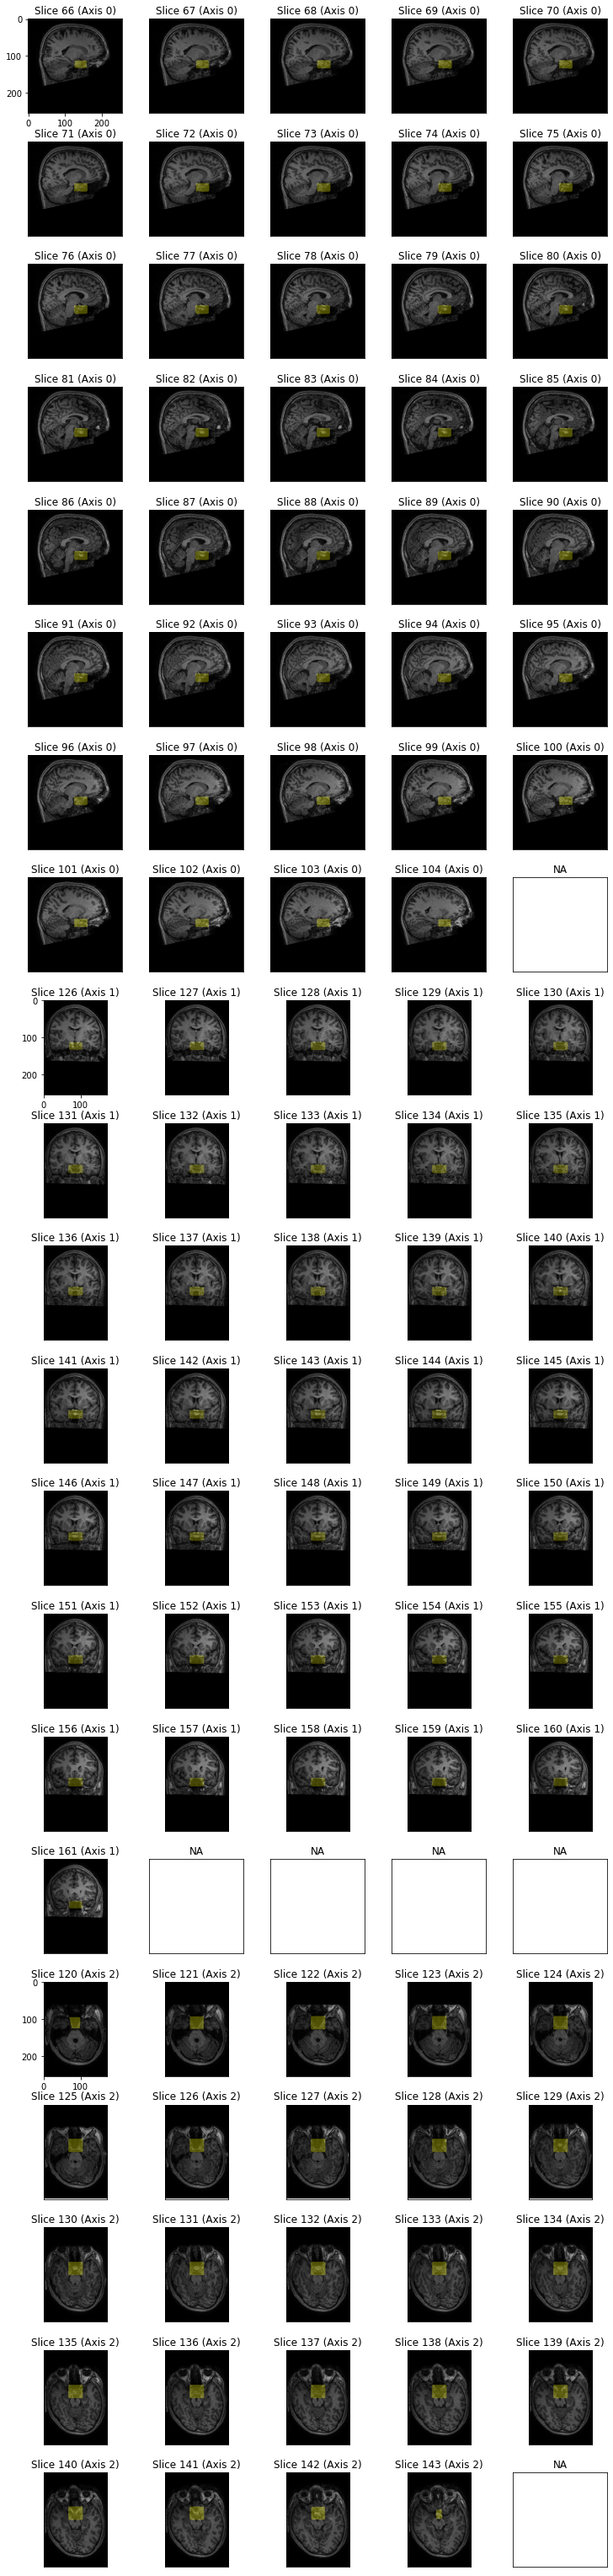

In [137]:
viz_bbox(0, iso_tls)

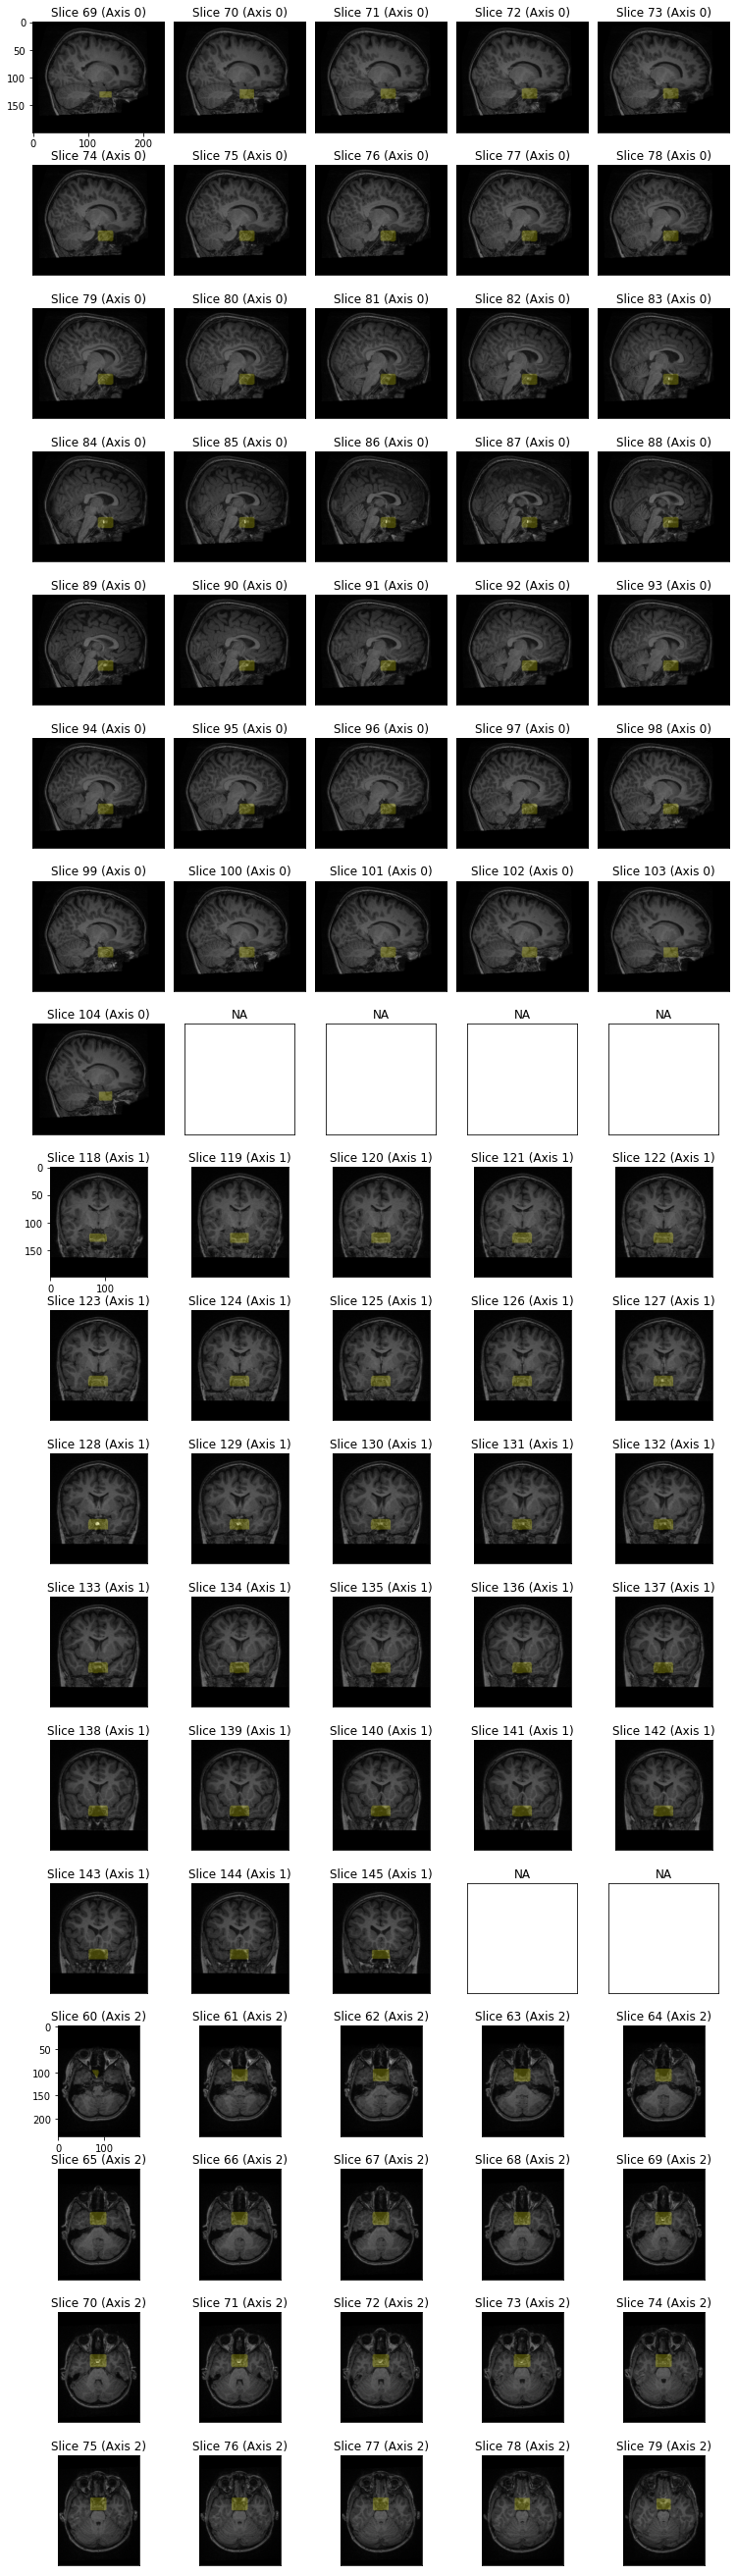

In [138]:
viz_bbox(1, iso_tls)

## Mask Bbox

Goal: find the range of slice indices that captures the sella of all inputs. Within a single standardized dataset, the slice indices should be similar.

Why? A full MR volume has >100 slices. The sella occupies about 10 of them. For quick testing, want the input to be MR with 20 slices and not >100 slices.

In [ ]:
# print w/ description
descr = ["imin", "imax", "jmin", "jmax", "kmin", "kmax"]
def bb_dict(bbox): return dict(zip(descr, bbox))

In [150]:
# subset of items in dset

subset = items

# start timer
start = time.time()

bboxs = TfmdLists(subset, [DoAll(1), GetBbox()])

# end timer
elapsed = time.time() - start
print(f"Elapsed: {elapsed} s for {len(subset)} items.")

# dataframe of imin/imax
mk_df = DF([{'fn': mr, **bb_dict(bboxs[i])} \
            for i,(mr, mk) in enumerate(subset)])

# irange is 62-108; jrange = 118-181; krange = 60-144
# => islices 50-150, jslices 100-200, kslices 0-200
for col in ("i", "j", "k"):
    col_min = mk_df[f"{col}min"].min()
    col_max = mk_df[f"{col}max"].max()
    print(f"{col} ROI Range: {col_min} - {col_max}")

# plot slice range
#mk_df.boxplot(column=descr)

Elapsed: 1.2706584930419922 s for 50 items.
i ROI Range: 56 - 157
j ROI Range: 111 - 181
k ROI Range: 21 - 153


In [155]:
general_bbox = [x for col in ("i", "j", "k") for x in (mk_df[f"{col}min"].min(), mk_df[f"{col}max"].max())]
print(general_bbox); print_bbox(*general_bbox)

[56, 157, 111, 181, 21, 153]
Bbox coords: (56, 111, 21) to (157, 181, 153). Size: 101, 70, 132.
Bounding box coord: from location (111, 21) of slice 56 to location (181, 153) of slice 157.


i ROI Range: 56 - 157
j ROI Range: 111 - 181
k ROI Range: 21 - 153
i ROI Range: 56 - 157
j ROI Range: 111 - 181
k ROI Range: 21 - 153


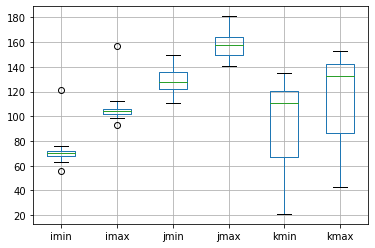

In [151]:
for col in ("i", "j", "k"):
    col_min = mk_df[f"{col}min"].min()
    col_max = mk_df[f"{col}max"].max()
    print(f"{col} ROI Range: {col_min} - {col_max}")
    
subset_df = mk_df[:len(items)]
subset_df.boxplot(column=descr)

for col in ("i", "j", "k"):
    col_min = subset_df[f"{col}min"].min()
    col_max = subset_df[f"{col}max"].max()
    print(f"{col} ROI Range: {col_min} - {col_max}")

In [68]:
# full

# i ROI Range: 18 - 226
# j ROI Range: 103 - 319
# k ROI Range: 9 - 289
    
subset = items_full

# start timer
start = time.time()

bboxs = TfmdLists(subset, [DoAll(1), GetBbox()])

# end timer
elapsed = time.time() - start
print(f"Elapsed: {elapsed} s for {len(subset)} items.")

# print w/ description
descr = ["imin", "imax", "jmin", "jmax", "kmin", "kmax"]
def bb_dict(bbox): return dict(zip(descr, bbox))

# dataframe of imin/imax
mk_df = DF([{'fn': mr, **bb_dict(bboxs[i])} \
            for i,(mr, mk) in enumerate(subset)])

# irange is 62-108; jrange = 118-181; krange = 60-144
# => islices 50-150, jslices 100-200, kslices 0-200
for col in ("i", "j", "k"):
    col_min = mk_df[f"{col}min"].min()
    col_max = mk_df[f"{col}max"].max()
    print(f"{col} ROI Range: {col_min} - {col_max}")

# plot slice range
#mk_df.boxplot(column=descr)

Elapsed: 432.53584480285645 s for 50 items.


<AxesSubplot:>

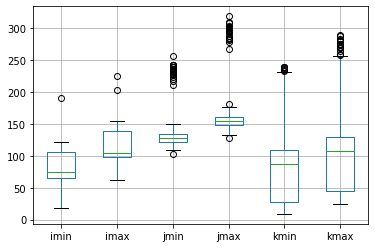

In [73]:
mk_df.boxplot(column=descr)

array([[<AxesSubplot:title={'center':'imin'}>,
        <AxesSubplot:title={'center':'imax'}>],
       [<AxesSubplot:title={'center':'jmin'}>,
        <AxesSubplot:title={'center':'jmax'}>],
       [<AxesSubplot:title={'center':'kmin'}>,
        <AxesSubplot:title={'center':'kmax'}>]], dtype=object)

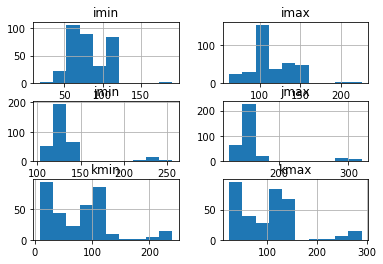

In [74]:
mk_df.hist(column=descr)

# Crop

In [220]:
# crop center
class CenterCropTfm(Transform):
    def __init__(self, size):
        self.size = size
        
    def encodes(self, arr):
        return self.cropND(arr, self.size)
    
    # https://stackoverflow.com/questions/39382412/crop-center-portion-of-a-numpy-image
    @staticmethod
    def cropND(img, bounding):
        start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
        end = tuple(map(operator.add, start, bounding))
        slices = tuple(map(slice, start, end))
        return img[slices]
    
# crop by coords
class CropBBox(Transform):
    def __init__(self, bbox):
        self.bbox = bbox
    
    def encodes(self, arr):
        imin, imax, jmin, jmax, kmin, kmax = self.bbox
        cropped = arr[imin:imax, jmin:jmax, kmin:kmax]
        
        # pad if needed
        new_size = [imax-imin, jmax-jmin, kmax-kmin]
        
        pad = [x-y for x,y in zip(new_size, arr.shape)]
        pad = [a for amt in pad for a in (amt//2, amt-amt//2)]
        pad.reverse()
        
        return F.pad(arr, pad, mode='constant', value=0)

In [222]:
# # which sizes are represented?

# class GetShape(ItemTransform):    
#     def encodes(self, x):
#         return np.array(x[1]).shape
    
# shapes = [GetShape()(i) for i in tls]
# print("PostTfm Sizes:"); print_unique(shapes)

In [223]:
# # reference bbox
# print_bbox(*general_box)

# Dataloaders

TODO augmentations.

- dset = tfms applied to items
- splits into training/valid
- bs

In [224]:
square_bbox = [66, 86, 118, 230, 60, 172]
print("Sq bbox", square_bbox)

Sq bbox [66, 86, 118, 230, 60, 172]


In [225]:
# splits
splits = RandomSplitter(seed=42)(items)
print(f"Training: {len(splits[0])}, Valid: {len(splits[1])}")

# tfms

#tfms = [PathToSitk(), IsotropicTfm(1), ToTensor3D(), CropBBox(square_bbox)] #, AddChannel()]

tfms = [DoAll(), CropBBox(general_bbox)] # square_bbox

# tls
tls = TfmdLists(items, tfms, splits=splits)

# dls
dls = tls.dataloaders(bs=2, after_batch=AddChannel())

# GPU
dls = dls.cuda()

# test get one batch
b = dls.one_batch()
print(type(b), b[0].shape, b[1].shape)
print(len(dls.train), len(dls.valid))

Training: 40, Valid: 10
<class 'tuple'> torch.Size([2, 1, 101, 70, 132]) torch.Size([2, 1, 101, 70, 132])
20 5


# Metric

Linear combination of Dice and Cross Entropy

In [226]:
def dice(input, target):
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return ((2. * intersection) /
           (iflat.sum() + tflat.sum()))

def dice_score(input, target):
    return dice(input.argmax(1), target)

def dice_loss(input, target): 
    return 1 - dice(input.softmax(1)[:, 1], target)

def loss(input, target):
    return dice_loss(input, target) + nn.CrossEntropyLoss()(input, target[:, 0])

In [227]:
# ipython nbconvert --to python  '6 - Dataloaders- NB - Simple-Copy1.ipynb'

# Learner

In [228]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [237]:
backbone = efficientnet_b0 #r3d_18 (pretrained?)
learn    = unet_learner_3d(dls, backbone, n_out=2,  metrics = dice_score)

# GPU
learn.model = learn.model.cuda()
#learn = learn.to_fp16()

In [ ]:
# learn = unet_learner_3d(dls, r3d_18, n_out=2, 
#                         loss_func = loss,
#                         metrics = dice_score,
#                         model_dir = REPO_DIR/'models',
#                         cbs = [SaveModelCallback(monitor='dice_score')]
#                        )
# learn = learn.to_fp16()

In [230]:
# test:

#dls.device = "cpu"

start = time.time()

x,y = dls.one_batch()
#x,y = to_cpu(x), to_cpu(y)

pred = learn.model(x)
loss = learn.loss_func(pred, y)

elapsed = time.time() - start

print(f"Elapsed: {elapsed} s")
print("Batch: x,y")
print(type(x), x.shape, x.dtype, "\n", type(y), y.shape, y.dtype)

print("Pred shape")
print(type(pred), pred.shape, pred.dtype)

print("Loss")
print(loss)
print(learn.loss_func)

Elapsed: 4.374827146530151
Batch: x,y
<class 'torch.Tensor'> torch.Size([2, 1, 101, 70, 132]) torch.float32 
 <class 'torch.Tensor'> torch.Size([2, 1, 101, 70, 132]) torch.int64
Pred shape
<class 'torch.Tensor'> torch.Size([2, 2, 101, 70, 132]) torch.float32
Loss
tensor(0.5653, device='cuda:0', grad_fn=<MeanBackward0>)


In [231]:
from fastai.callback.all import *
print(learn.show_training_loop())

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : []
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epoch Loop
   - after_

In [232]:
learn.summary()

DynamicUnet3D (Input shape: 2)
Layer (type)         Output Shape         Param #    Trainable 
                     []                  
ConstantPad3d                                                  
____________________________________________________________________________
                     2 x 32 x 51 x 35 x  
Conv3d                                    864        False     
BatchNorm3d                               64         True      
____________________________________________________________________________
                     []                  
ConstantPad3d                                                  
____________________________________________________________________________
                     2 x 32 x 51 x 35 x  
Conv3d                                    864        False     
BatchNorm3d                               64         True      
SiLU                                                           
ConstantPad3d                                             

# LR Finder

In [233]:
train = learn.dls.train
print(len(train))

20


SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.2089296132326126)

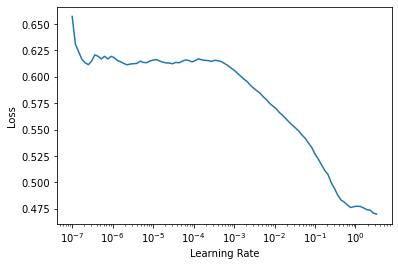

In [236]:
learn.lr_find()

In [238]:
print("PRE learn.fit one cycle")
learn.fit_one_cycle(1, 3e-1, wd = 1e-4)

PRE learn.fit one cycle


epoch,train_loss,valid_loss,dice_score,time
0,0.424908,0.610602,0.077067,00:31


In [ ]:
print("unfreeze, learn 50")
learn.unfreeze()
learn.fit_one_cycle(50, 3e-3, wd = 1e-4)

unfreeze, learn 50


epoch,train_loss,valid_loss,dice_score,time
0,0.310232,0.328858,0.349853,00:35
1,0.305128,0.300676,0.248583,00:35
2,0.298281,0.287270,0.341916,00:35
3,0.287488,0.266072,0.507983,00:35
4,0.271086,0.235373,0.490968,00:35
5,0.250404,0.250527,0.367101,00:35
6,0.232461,0.233408,0.497551,00:35
7,0.214318,0.204818,0.551471,00:35
8,0.197701,0.183061,0.597465,00:35
9,0.179871,0.158521,0.637779,00:35


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=6.309573450380412e-07)

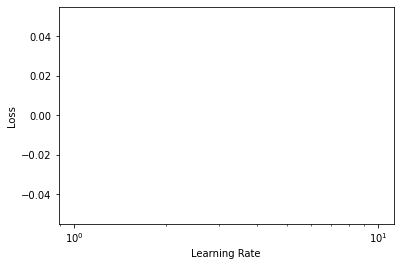

In [72]:
learn.lr_find()

In [ ]:
print("unfreeze, learn 50")
# learn.unfreeze()
# learn.fit_one_cycle(50, 1e-3, wd = 1e-4)

In [137]:
# testmask = torch.tensor([[[False, False, False], [False, False, False], [True, True, True]],
#                        [[False, False, False], [False, False, True], [True, True, True]],
#                        [[False, False, False], [False, False, False], [False, False, False]]])
# testmask

In [138]:
# testmaskN = np.array(testmask)
# testmaskN

In [139]:
# maskT = testmask.type(torch.BoolTensor)

# iT = torch.any(maskT, dim=(1,2))
# jT = torch.any(maskT, dim=(0,2))
# kT = torch.any(maskT, dim=(0,1))

# iminT, imaxT = torch.where(iT)[0][[0, -1]]
# jminT, jmaxT = torch.where(jT)[0][[0, -1]]
# kminT, kmaxT = torch.where(kT)[0][[0, -1]]

In [140]:
# maskN = np.array(testmask).astype(bool)
    
# iN = np.any(maskN, axis=(1, 2))
# jN = np.any(maskN, axis=(0, 2))
# kN = np.any(maskN, axis=(0, 1))

# iminN, imaxN = np.where(iN)[0][[0, -1]]
# jminN, jmaxN = np.where(jN)[0][[0, -1]]
# kminN, kmaxN = np.where(kN)[0][[0, -1]]

In [141]:
# maskT.shape, maskN.shape

In [142]:
# print(iT)
# print(jT)
# print(kT)
# print([x for x in (iminT, imaxT, jminT, jmaxT, kminT, kmaxT)])

In [143]:
# print(iN)
# print(jN)
# print(kN)
# print([int(x) for x in (iminN, imaxN, jminN, jmaxN, kminN, kmaxN)])

In [ ]:
#     def torch_mask2bbox(mask):
#         mask = mask.type(torch.BoolTensor)

#         i = torch.any(mask, dim=0)
#         j = torch.any(mask, dim=1)
#         k = torch.any(mask, dim=2)

#         imin, imax = torch.where(i)[0][[0, -1]]
#         jmin, jmax = torch.where(j)[0][[0, -1]]
#         kmin, kmax = torch.where(k)[0][[0, -1]]

#         # inclusive idxs
#         return imin, imax+1, jmin, jmax+1, kmin, kmax+1